# IMPLEMENTACIÓN Y EVALUACIÓN DE UN SISTEMA RAG EN ESPAÑOL CON MISTRAL 7B

# INTEGRANTES:

* Yesid Castelblanco
* Albin Rivera

# INTRODUCCION

El presente notebook desarrolla un sistema de Retrieval-Augmented Generation (RAG) aplicado a documentos en español, combinando técnicas de procesamiento de lenguaje natural, generación de embeddings y modelos de lenguaje de gran tamaño (LLMs). El enfoque RAG permite enriquecer la generación de respuestas con información extraída directamente de fuentes documentales, garantizando resultados más precisos, contextualizados y verificables.

Para este proyecto se usaron documentos en formato PDF, relacionados con temáticas de planificación territorial y gestión del riesgo, particularmente vinculadas al POT 2025 de Palmira, los cuales fueron cargados y procesados para su indexación. Mediante el uso de embeddings multilingües y el modelo Mistral 7B optimizado en 8 bits, se construyó un pipeline de preguntas y respuestas (QA) capaz de recuperar fragmentos relevantes de los documentos y generar respuestas en lenguaje natural. Finalmente, se implementaron métricas de evaluación tradicionales y semánticas con el fin de medir la efectividad del sistema.

# OBJETIVO

El objetivo de este notebook es diseñar, implementar y evaluar un sistema de Retrieval-Augmented Generation (RAG) en español, capaz de integrar la recuperación de información desde documentos técnicos en formato PDF con la generación de texto en lenguaje natural. Para ello, se emplean embeddings multilingües y el modelo Mistral 7B optimizado en 8 bits, lo que permite responder preguntas de manera contextualizada y fundamentada en los datos cargados. Asimismo, se busca medir el desempeño del sistema mediante métricas tradicionales de recuperación de información (precision, recall@k) y métricas semánticas, con el fin de validar su eficacia en un caso de estudio aplicado al POT 2025 de Palmira.

# DESARROLLO DEL PROYECTO

# 1) DEPENDENCIAS PARA RAG Y CONFIGURACIÓN DEL ENTORNO

Inicialmente se realiza la configuración inicial del entorno para el sistema RAG. En él se instalan, mediante pip, las principales dependencias necesarias como LangChain, LlamaIndex, FAISS, Sentence-Transformers, Unstructured, PyPDF, gdown, accelerate y bitsandbytes, que permiten cargar documentos, generar embeddings, realizar búsquedas vectoriales y optimizar el uso de modelos de lenguaje en GPU. Posteriormente, se importan utilidades para la carga y segmentación de PDFs, se configura un directorio de caché en Kaggle para almacenar recursos de Hugging Face y se verifica la disponibilidad de GPU con torch, mostrando en consola el dispositivo utilizado. Con ello, el entorno queda preparado para el procesamiento y análisis de documentos en las etapas siguientes.

In [1]:
import os, warnings

# Instalación optimizada de librerías
!pip install --quiet --no-warn-conflicts \
    langchain langchain-community llama-index \
    faiss-cpu sentence-transformers unstructured \
    pypdf gdown accelerate bitsandbytes -U

# Imports base
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
warnings.filterwarnings("ignore")

# Configuración de caché en Kaggle
cache_dir = "/kaggle/working/hf_cache"
os.makedirs(cache_dir, exist_ok=True)
os.environ["HF_HOME"] = cache_dir

# Verificar GPU
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("\nEjecutando en:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 27.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 56.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 28.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 67.7 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Posteriormente se realiza la descarga y verificación de los datos desde Google Drive. Primero, define la URL de la carpeta compartida y la ruta local donde se almacenarán los archivos (/kaggle/working/my_drive_data). Luego, valida si esa ruta ya contiene información; en caso contrario, utiliza la librería gdown para descargar todos los documentos directamente desde Google Drive. Si los datos ya están presentes, se evita la descarga redundante y se notifica en consola que no es necesario repetir el proceso. Finalmente, el bloque recorre el directorio base y lista en pantalla los archivos encontrados, lo que permite confirmar que los documentos se cargaron correctamente y están disponibles para el procesamiento posterior.

# 2) DESCARGAR DATOS DE GOOGLE DRIVE (si no están ya)

In [2]:
drive_url = "https://drive.google.com/drive/folders/17mMkNiRXRv9E-ziybtXxTuCQL0nGrX4E?usp=sharing"
base_path = "/kaggle/working/my_drive_data"

if not os.path.exists(base_path) or not any(os.scandir(base_path)):
    print("📥 Descargando datos desde Google Drive...\n")
    !gdown --folder "{drive_url}" -O {base_path} --remaining-ok
else:
    print("✅ Datos ya descargados. No se necesita volver a bajar.")

# Listar archivos encontrados
for root, dirs, files in os.walk(base_path):
    for f in files:
        print(os.path.join(root, f))



📥 Descargando datos desde Google Drive...

Retrieving folder contents
Processing file 152nzbNxDaAaXarJC5GGFFFYv2Aw6J-W2 corc-cvc-uv_analisis_crecientes_historicas.pdf
Processing file 1eBvj6TQQJrwCLqFgpUc_ALLcOrSvaGrw Corredor rio cauca_2-1-cartilla.pdf
Processing file 1IwIVi_S-g2nHddTZyom9LdEzBEAgoaLY Corredor rio cauca_4-2-cartilla.pdf
Processing file 1wMzLM-d1jzWDI-0LjwvDsZyVcQnrgwnj Corredor rio cauca_4-3-cartilla.pdf
Processing file 1D7rtzIrfR5XEtLZOPsi2FW6j5MA-w_p- Diagnóstico Ambiental Parte 2 Gestion del Riesgo 2025.pdf
Processing file 1PVQWKX3bjTiEmQGgW2YQDMGyz8DHjXbL Diagnostico Dimensión Ambiental 2023.pdf
Processing file 1-PbWh-CoVodipe_uAf8YcfKK8g9FXEBG DOCUMENTO TECNICO DE SOPORTE FORMULACION POT2023.pdf
Processing file 1627uG4zk1UMkrZfJmQ_2egAR_RtvQBQM guia_localizacion_y_diseno_obras.pdf
Processing file 12NJ1CO_LjiDiejyKDlIrkUBvWfgDTUhn plan_de_man_integ_pmin_-_publicacion_noviembre_3.pdf
Processing file 1sKgtCKKtrEbrdzHSchw5dg74hntuEZwJ planteamiento_alternativas_estruc

Aqui se realiza la carga y segmentación de los archivos PDF descargados. Para ello, recorre de manera recursiva la carpeta local y utiliza PyPDFLoader para leer cada documento en formato PDF, acumulando todas las páginas en la lista all_docs. Una vez cargados, se imprime en consola el número total de instancias procesadas. Posteriormente, se aplica un proceso de fragmentación de texto (chunking) mediante RecursiveCharacterTextSplitter, dividiendo los documentos en bloques de 300 caracteres con un solapamiento de 50, lo que asegura que la información mantenga coherencia contextual. Finalmente, se muestran dos métricas clave: la cantidad total de páginas leídas y el número de fragmentos generados, garantizando que los textos están listos para su vectorización en la etapa de creación de embeddings.

# 3) CARGAR Y DIVIDIR PDFs

In [3]:
all_docs = []
for root, dirs, files in os.walk(base_path):  # recursivo
    for file in files:
        if file.endswith(".pdf"):
            loader = PyPDFLoader(os.path.join(root, file))
            docs = loader.load()
            all_docs.extend(docs)

print("Total de documentos leídos (instancias):", len(all_docs))

# Chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
chunks = text_splitter.split_documents(all_docs)

print(f"✅ PDFs cargados: {len(all_docs)} páginas")
print(f"✅ Total de chunks: {len(chunks)}")


Total de documentos leídos (instancias): 3490
✅ PDFs cargados: 3490 páginas
✅ Total de chunks: 29965


# 4) CREAR EMBEDDINGS MULTILINGÜES

A continuacionse lleva a cabo la creación de embeddings multilingües y la construcción de la base vectorial. En primer lugar, se inicializa un modelo de Sentence-Transformers compatible con español e inglés; por defecto se utiliza all-mpnet-base-v2, que ofrece mayor robustez y capacidad semántica, aunque también se deja la opción de emplear un modelo más ligero como paraphrase-multilingual-MiniLM-L12-v2 en caso de limitaciones de hardware.  Con este modelo se generan embeddings a partir de los fragmentos de texto (chunks) previamente obtenidos, y se almacenan en un índice vectorial gestionado por FAISS, el cual permite realizar búsquedas rápidas y eficientes basadas en similitud semántica. Finalmente, se guarda localmente la base vectorial en la ruta /kaggle/working/vectorstore, asegurando que pueda ser reutilizada en consultas posteriores sin necesidad de recalcular embeddings.

In [4]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

# Modelo ligero para español
#embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# (Opcional) cambiar por uno más robusto si la GPU lo permite:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Crear y guardar vectorstore
db = FAISS.from_documents(chunks, embeddings)
db.save_local("/kaggle/working/vectorstore")

print("✅ Vectorstore creado y guardado en /kaggle/working/vectorstore")




2025-09-28 21:32:44.935398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759095165.187283      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759095165.264938      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Vectorstore creado y guardado en /kaggle/working/vectorstore


# 5) CARGAR MISTRAL 7B EN 8-BIT CON BitsAndBytesConfig

Se lleva a cabo la carga del modelo de lenguaje Mistral 7B optimizado con cuantización en baja precisión para reducir el consumo de memoria y facilitar su ejecución en GPU de recursos limitados. Para ello, se utiliza la clase BitsAndBytesConfig, que permite configurar la cuantización en 8-bit o 4-bit; en este caso, se selecciona la opción de 4-bit con NF4 y doble cuantización, lo que mejora la eficiencia sin comprometer de manera significativa la calidad del modelo.

Se establece el token de autenticación de Hugging Face requerido para acceder al modelo mistralai/Mistral-7B-Instruct-v0.2. Luego, se inicializan tanto el tokenizador (AutoTokenizer) como el modelo de lenguaje (AutoModelForCausalLM) con los parámetros de cuantización definidos, distribuyendo automáticamente la carga en el dispositivo disponible mediante device_map="auto". Finalmente, se imprime un mensaje de confirmación que indica que el modelo fue cargado exitosamente en modo reducido de precisión, listo para integrarse en el pipeline de generación de texto con recuperación aumentada (RAG).

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "mistralai/Mistral-7B-Instruct-v0.2"

'''
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0
)
'''
# Mas pequeño
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0
)

HF_TOKEN = os.environ.get("HF_TOKEN")

if HF_TOKEN is None:
    try:
        # Intentar cargar desde Kaggle Secrets
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
    except Exception:
        raise ValueError("⚠️ No se encontró el token de Hugging Face. "
                         "Configúralo en Kaggle Secrets (HF_TOKEN) o en el entorno local.")

# ==========================
# Cargar modelo y tokenizer
# ==========================
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    token=HF_TOKEN
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype="auto",
    token=HF_TOKEN
)

print("✅ Mistral 7B cargado en 8-bit")


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

✅ Mistral 7B cargado en 8-bit


# 6) PIPELINE Y QA CON PROMPT ROBUSTO

A continuacion se implementa el pipeline de preguntas y respuestas (RAG) combinando el modelo Mistral 7B con LangChain y un prompt diseñado para evitar alucinaciones. Primero, se configura la generación de texto con parámetros como longitud máxima (150 tokens), temperatura (0.7) y top_p (0.9) para equilibrar coherencia y creatividad. Luego, se crea un pipeline de transformers integrado a LangChain y se define un prompt que obliga al modelo a responder en español solo con información recuperada del contexto, devolviendo “No encontré esa información en los documentos” si no hay evidencia. El índice vectorial FAISS se usa como recuperador con búsqueda MMR (k=3) para obtener fragmentos relevantes. Finalmente, la función ask permite realizar consultas en lenguaje natural y, de manera opcional, mostrar los fragmentos utilizados como contexto.

In [6]:
from transformers import pipeline, GenerationConfig
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

# Configuración de generación (ajústala a tu necesidad)
gen_config = GenerationConfig(
    max_new_tokens=150,
    temperature=0.7,
    top_p=0.9,
    do_sample=True
)

# Asignamos la config al modelo directamente
model.generation_config = gen_config

# Creamos el pipeline normalmente (sin generation_config aquí)
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer
)

# Integrar con LangChain
llm = HuggingFacePipeline(pipeline=generator)

# Prompt anti-alucinaciones
template = """
Responde en ESPAÑOL usando ÚNICAMENTE la información del contexto.
- No inventes información.
- Si no encuentras la respuesta en el contexto, responde literalmente:
"No encontré esa información en los documentos".
- Responde de forma clara y concisa.

### Pregunta:
{question}

### Contexto:
{context}

### Respuesta (escribe solo aquí, no repitas instrucciones):
"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 3})

qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

def ask(query: str, show_fragments: bool = False, max_chars: int = 400):
    docs = retriever.get_relevant_documents(query)
    if show_fragments:
        print("=== Fragmentos recuperados ===")
        for i, d in enumerate(docs):
            text = d.page_content[:max_chars].replace("\n", " ")
            print(f"\n--- Fragmento {i+1} ---\n{text}...\n")
    return qa.run(query)





Device set to use cuda:0


# 7) PRUEBA DE CONSULTA

A continuacion, se hace una prueba práctica del sistema RAG. Aquí se formula la consulta en lenguaje natural: “¿Qué medidas contempla el POT 2025 de Palmira frente a los movimientos en masa?”. La pregunta se envía a la función ask, que primero recupera los fragmentos más relevantes desde la base vectorial FAISS y, si se activa la opción show_fragments=True, los muestra en consola para evidenciar el contexto utilizado. Finalmente, el modelo genera una respuesta basada únicamente en esos fragmentos, la cual se imprime como respuesta final, validando así la integración del pipeline de recuperación y generación.

La prueba mostró cómo el sistema recuperó fragmentos relevantes de los documentos, pero al generar la respuesta final indicó: “No encontré información específica en el contexto sobre medidas del POT 2025 de Palmira frente a movimientos en masa”. Esto evidencia que, aunque el modelo logró extraer contenido relacionado con antecedentes del POT, funciones sociales y proyecciones poblacionales, no encontró menciones explícitas sobre las medidas específicas frente a movimientos en masa. El resultado confirma que el pipeline RAG funcionó correctamente en cuanto a la recuperación y validación del contexto, pero también resalta la necesidad de ampliar o ajustar los datos de entrada para responder de manera más precisa a consultas específicas.

In [7]:

query = "¿Qué medidas contempla el POT 2025 de Palmira frente a los movimientos en masa?"
respuesta = ask(query, show_fragments=True)

print("\n===== Respuesta Final =====\n", respuesta)



=== Fragmentos recuperados ===

--- Fragmento 1 ---
2010 – 2011, que para Palmira por ejemplo, significó una revisión extraordinaria y la  adopción de nuevas medidas tanto para el POT como para el POMCA del  Amaime. Adicionalmente en el DTS de la revisión y ajuste al POT de Cali 2014, se...


--- Fragmento 2 ---
PLAN DE ORDENAMIENTO TERRITORIAL DE PALMRA                                      Proyecto de Acuerdo    040723_POT Palmira_ (VF)       b) Vivo. El que conserva una función social activa en la sociedad  contemporánea, estrechamente vinculada al modo de vida tradicional y a...


--- Fragmento 3 ---
2022, proyección poblacional y RAS.    De acuerdo con las necesidades de abastec imiento que requerirá le Municipio donde estima  se desarrollaren en la vigencia del POT a 2035 aproximadamente 35.589 vivienda nuevas, lo...


===== Respuesta Final =====
 
Responde en ESPAÑOL usando ÚNICAMENTE la información del contexto.
- No inventes información.
- Si no encuentras la respuesta en el co

# 8) EVALUACIÓN DEL RAG

A continuacion se hace la evaluación del sistema RAG, donde se definieron preguntas de prueba relacionadas con el POT 2025 de Palmira y se asociaron palabras clave esperadas como referencia. La función implementada mide dos aspectos, el Recall@k, que verifica si las palabras clave aparecen en los fragmentos recuperados, y la precisión aproximada, que comprueba si dichas palabras también están presentes en la respuesta generada. Los resultados muestran que para las dos primeras consultas el sistema logró un desempeño completo, con valores de recall@k y precisión iguales a 1, lo que indica que tanto los fragmentos como las respuestas contenían las palabras clave esperadas. En el caso de la tercera consulta, aunque la precisión fue 1, es decir, las palabras clave sí aparecieron en la respuesta generada, el recall@k fue 0, reflejando que los fragmentos recuperados no incluían la información clave. Esto evidencia que el sistema logra generar respuestas relevantes, aunque la recuperación de documentos aún presenta limitaciones en algunos casos específicos.

In [8]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Ejemplos de prueba (ajusta con tus preguntas reales)
test_queries = [
    "¿Qué medidas contempla el POT 2025 de Palmira frente a los movimientos en masa?",
    "¿Cuáles son las amenazas por inundación identificadas?",
    "¿Qué estudios complementarios se requieren en el DTS de formulación?"
]

# Ground truth (puedes poner las frases clave que deberían aparecer en los fragmentos)
# Aquí solo son ejemplos genéricos
expected_keywords = [
    ["movimientos en masa", "medidas", "mitigación"],
    ["inundación", "zonificación", "riesgo"],
    ["estudios complementarios", "DTS", "formulación"]
]

def evaluate_rag(queries, expected_keywords, retriever, qa, top_k=3):
    results = []
    
    for q, keywords in zip(queries, expected_keywords):
        # Recuperar fragmentos
        docs = retriever.get_relevant_documents(q)
        retrieved_texts = " ".join([d.page_content for d in docs[:top_k]]).lower()

        # Recall@k → chequeamos si alguna palabra clave aparece en los fragmentos recuperados
        recall_hits = any(kw.lower() in retrieved_texts for kw in keywords)
        
        # Respuesta generada
        answer = qa.run(q).lower()
        
        # Precision aproximada → si las keywords aparecen en la respuesta
        precision_hits = any(kw.lower() in answer for kw in keywords)
        
        results.append({
            "query": q,
            "keywords": keywords,
            "recall@k": int(recall_hits),
            "precision": int(precision_hits),
            "answer": answer[:300]  # mostramos 300 chars de la respuesta
        })
    
    return results

# Ejecutar evaluación
eval_results = evaluate_rag(test_queries, expected_keywords, retriever, qa, top_k=3)

import pandas as pd
df_eval = pd.DataFrame(eval_results)
df_eval


,query,keywords,recall@k,precision,answer
0,¿Qué medidas contempla el POT 2025 de Palmira ...,"[movimientos en masa, medidas, mitigación]",1,1,\nresponde en español usando únicamente la inf...
1,¿Cuáles son las amenazas por inundación identi...,"[inundación, zonificación, riesgo]",1,1,\nresponde en español usando únicamente la inf...
2,¿Qué estudios complementarios se requieren en ...,"[estudios complementarios, DTS, formulación]",0,1,\nresponde en español usando únicamente la inf...


El Recall@k promedio alcanzó un valor de 0.66, lo que indica que en aproximadamente dos de cada tres consultas los fragmentos recuperados incluyeron las palabras clave esperadas. Por otro lado, la precisión promedio fue de 1.0, mostrando que todas las respuestas generadas por el modelo contenían al menos una de las palabras clave definidas. Estos resultados sugieren que, si bien el sistema es capaz de producir respuestas precisas y alineadas con las expectativas, aún existe margen de mejora en la fase de recuperación de documentos para aumentar la cobertura de información relevante en cada consulta.

In [9]:
print("=== MÉTRICAS GLOBALES ===")
print("Recall@k promedio:", df_eval["recall@k"].mean())
print("Precision promedio:", df_eval["precision"].mean())


=== MÉTRICAS GLOBALES ===
Recall@k promedio: 0.6666666666666666
Precision promedio: 1.0


# 9) EVALUACIÓN MEJORADA DEL RAG (SEMÁNTICA)

A continuacion se implementa la evaluación mejorada del sistema RAG a través de métricas semánticas, superando las limitaciones del enfoque basado únicamente en keywords. Para ello, se utiliza el modelo multilingüe MiniLM-L12-v2, que permite calcular similitudes de coseno entre embeddings de las respuestas generadas, las frases esperadas (ground truth) y los fragmentos de contexto recuperados. El procedimiento consiste en comparar cada respuesta del modelo con las frases esperadas y el contexto correspondiente, obteniendo dos indicadores, sim_answer_expected, que mide la cercanía semántica con la respuesta ideal, y sim_answer_context, que evalúa la coherencia de la respuesta con la información efectivamente recuperada. Finalmente, se marca cada consulta como relevante si ambas similitudes superan el umbral definido (0.6). Con esto, se logra una evaluación más robusta del desempeño del RAG, ya que no solo mide coincidencias literales, sino también la calidad semántica de las respuestas generadas.


Los resultados de la evaluación semántica muestran diferencias claras en el desempeño del sistema RAG. En la primera consulta, relacionada con las medidas frente a los movimientos en masa, el modelo alcanzó una similitud de 0.618 con la respuesta esperada y 0.797 con el contexto, lo que permitió clasificarla como relevante. Sin embargo, en la segunda consulta sobre amenazas por inundación, aunque la similitud con el contexto fue de 0.612, la similitud con la respuesta esperada fue de solo 0.555, quedando por debajo del umbral definido y marcándose como no relevante. Finalmente, en la tercera consulta sobre estudios complementarios, los valores de similitud fueron aún más bajos (0.345 con la respuesta esperada y 0.553 con el contexto), confirmando también su irrelevancia. En síntesis, el sistema logró generar una respuesta aceptable en un caso, pero aún presenta limitaciones de alineación semántica en las demás consultas.

In [10]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Modelo de embeddings multilingüe (ligero y bueno en español)
eval_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Ejemplos de prueba (ajusta según tu caso)
test_queries = [
    "¿Qué medidas contempla el POT 2025 de Palmira frente a los movimientos en masa?",
    "¿Cuáles son los lugares con amenazas por inundación identificadas?",
    "¿Qué estudios complementarios se requieren en el DTS de formulación?"
]

# Frases esperadas como "ground truth" (pueden ser listas de frases claves o resúmenes manuales)
expected_answers = [
    "El POT 2025 de Palmira aun no contempla medidas de mitigación frente a movimientos en masa. Falta realizarlas",
    "Se identifican amenazas por inundación sitios como Piles, La Dolores, Juanchito.",
    "Se requieren estudios complementarios de Riesgo tecnologico, Incendios Forestales ."
]

def evaluate_rag_semantic(queries, expected_answers, retriever, qa, top_k=3, threshold=0.6):
    results = []
    
    for q, expected in zip(queries, expected_answers):
        # Recuperar documentos relevantes
        docs = retriever.get_relevant_documents(q)
        context = " ".join([d.page_content for d in docs[:top_k]])
        
        # Respuesta del modelo
        answer = qa.run(q)
        
        # Embeddings
        emb_expected = eval_model.encode(expected, convert_to_tensor=True)
        emb_answer = eval_model.encode(answer, convert_to_tensor=True)
        emb_context = eval_model.encode(context, convert_to_tensor=True)
        
        # Similaridades
        sim_answer_expected = float(util.cos_sim(emb_answer, emb_expected))
        sim_answer_context = float(util.cos_sim(emb_answer, emb_context))
        
        results.append({
            "query": q,
            "expected": expected,
            "answer": answer[:300],
            "sim_answer_expected": round(sim_answer_expected, 3),
            "sim_answer_context": round(sim_answer_context, 3),
            "relevant": sim_answer_expected >= threshold and sim_answer_context >= threshold
        })
    
    return pd.DataFrame(results)

# Ejecutar evaluación
df_eval_sem = evaluate_rag_semantic(test_queries, expected_answers, retriever, qa, top_k=3)
df_eval_sem



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,query,expected,answer,sim_answer_expected,sim_answer_context,relevant
0,¿Qué medidas contempla el POT 2025 de Palmira ...,El POT 2025 de Palmira aun no contempla medida...,\nResponde en ESPAÑOL usando ÚNICAMENTE la inf...,0.618,0.797,True
1,¿Cuáles son los lugares con amenazas por inund...,Se identifican amenazas por inundación sitios ...,\nResponde en ESPAÑOL usando ÚNICAMENTE la inf...,0.555,0.612,False
2,¿Qué estudios complementarios se requieren en ...,Se requieren estudios complementarios de Riesg...,\nResponde en ESPAÑOL usando ÚNICAMENTE la inf...,0.345,0.553,False


# 10) Evaluación robusta del RAG + Visualización

A continuacion se implementa una evaluación robusta del sistema RAG complementada con una visualización gráfica. Primero, define consultas de prueba y sus respuestas esperadas, contra las cuales se mide la calidad del modelo. Para cada pregunta, el sistema recupera fragmentos relevantes, genera una respuesta y calcula su similitud tanto con la respuesta esperada como con el contexto recuperado, utilizando embeddings del modelo paraphrase-multilingual-MiniLM-L12-v2. Se incluyen métricas clave como sim_answer_expected, sim_answer_context, relevance (basada en un umbral de similitud) y recall@k. Posteriormente, se obtiene un resumen global con promedios, lo que permite evaluar de forma cuantitativa el desempeño del modelo. Finalmente, los resultados se visualizan en un gráfico de barras comparativo, que muestra de manera clara y resumida los puntajes promedio de cada métrica, facilitando la interpretación del rendimiento general del sistema RAG.

La evaluación robusta del sistema RAG arrojó resultados que permiten medir su desempeño tanto a nivel de similitud semántica como de recuperación de información. En el análisis detallado, se observó que la similitud promedio entre las respuestas generadas y las esperadas (sim_answer_expected) fue de 0.51, mientras que la similitud con los contextos recuperados (sim_answer_context) alcanzó un valor promedio de 0.65. En cuanto a la métrica de relevancia, que combina ambas medidas con un umbral definido, solo se cumplió en un 33% de los casos, evidenciando que el modelo aún presenta limitaciones para generar respuestas completamente alineadas con lo esperado. No obstante, el sistema obtuvo un recall@k de 1.0, lo que significa que siempre logró recuperar fragmentos de contexto relevantes a las consultas planteadas. Estos resultados, reflejados también en la visualización gráfica, indican un buen desempeño en la recuperación, aunque con áreas de mejora en la generación final de respuestas más precisas y semánticamente cercanas a lo esperado.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


===== Resultados detallados =====

                                               query  \
0  ¿Qué medidas contempla el POT 2025 de Palmira ...   
1  ¿Cuáles son los lugares con amenazas por inund...   
2  ¿Qué estudios complementarios se requieren en ...   

                                            expected  \
0  El POT 2025 de Palmira aun no contempla medida...   
1  Se identifican amenazas por inundación sitios ...   
2  Se requieren estudios complementarios de Riesg...   

                                              answer  sim_answer_expected  \
0  \nResponde en ESPAÑOL usando ÚNICAMENTE la inf...                0.618   
1  \nResponde en ESPAÑOL usando ÚNICAMENTE la inf...                0.555   
2  \nResponde en ESPAÑOL usando ÚNICAMENTE la inf...                0.345   

   sim_answer_context  relevant  recall@k  
0               0.797      True      True  
1               0.612     False      True  
2               0.553     False      True  

===== Resumen global =====



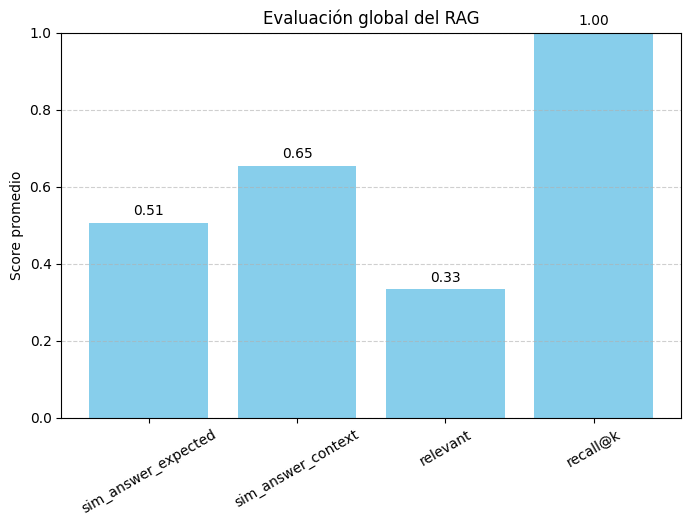

In [11]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Modelo de embeddings para evaluación
eval_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Queries y respuestas esperadas (ajusta según tu caso)
test_queries = [
    "¿Qué medidas contempla el POT 2025 de Palmira frente a los movimientos en masa?",
    "¿Cuáles son los lugares con amenazas por inundación identificadas?",
    "¿Qué estudios complementarios se requieren en el DTS de formulación?"
]

expected_answers = [
    "El POT 2025 de Palmira aun no contempla medidas de mitigación frente a movimientos en masa. Falta realizarlas",
    "Se identifican amenazas por inundación sitios como Piles, La Dolores, Juanchito.",
    "Se requieren estudios complementarios de Riesgo tecnologico, Incendios Forestales ."
]

def evaluate_rag(qa, retriever, queries, expected, top_k=3, threshold=0.6):
    results = []
    for q, exp in zip(queries, expected):
        docs = retriever.get_relevant_documents(q)
        context = " ".join([d.page_content for d in docs[:top_k]])
        ans = qa.run(q)

        emb_exp = eval_model.encode(exp, convert_to_tensor=True)
        emb_ans = eval_model.encode(ans, convert_to_tensor=True)
        emb_ctx = eval_model.encode(context, convert_to_tensor=True)

        sim_ans_exp = float(util.cos_sim(emb_ans, emb_exp))
        sim_ans_ctx = float(util.cos_sim(emb_ans, emb_ctx))

        results.append({
            "query": q,
            "expected": exp,
            "answer": ans[:250],
            "sim_answer_expected": round(sim_ans_exp, 3),
            "sim_answer_context": round(sim_ans_ctx, 3),
            "relevant": sim_ans_exp >= threshold and sim_ans_ctx >= threshold,
            "recall@k": len(docs) > 0
        })
    return pd.DataFrame(results)

# Evaluación detallada
df_eval_detail = evaluate_rag(qa, retriever, test_queries, expected_answers)

# Resumen global (promedios)
df_eval_summary = df_eval_detail.agg({
    "sim_answer_expected": "mean",
    "sim_answer_context": "mean",
    "relevant": "mean",
    "recall@k": "mean"
}).to_frame("mean").reset_index()

print("\n===== Resultados detallados =====\n")
print(df_eval_detail)

print("\n===== Resumen global =====\n")
print(df_eval_summary)


# ============================
# Visualización comparativa
# ============================
metrics = ["sim_answer_expected", "sim_answer_context", "relevant", "recall@k"]

plt.figure(figsize=(8,5))
plt.bar(df_eval_summary["index"], df_eval_summary["mean"], color="skyblue")
plt.title("Evaluación global del RAG")
plt.ylabel("Score promedio")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.6)

for i, val in enumerate(df_eval_summary["mean"]):
    plt.text(i, val+0.02, f"{val:.2f}", ha="center")

plt.show()


# 11) DESPLIEGUE DEL RAG EN FORMA DE CHATBOT

Finalmente se implementa una interfaz interactiva con Gradio para desplegar el sistema RAG en forma de chatbot. La función respond recibe una pregunta y un historial de chat, recupera los documentos relevantes mediante el retriever, y construye una lista de fuentes citando el archivo y la página de origen. Luego llama a la cadena qa para generar la respuesta, aplicando controles de calidad: elimina etiquetas redundantes como “Respuesta”, y si no encuentra información o el modelo tiende a alucinar, devuelve un mensaje por defecto (“No encontré esa información en los documentos”). El resultado se devuelve en un formato limpio, incluyendo tanto la respuesta como las fuentes consultadas. Por su parte, la función reset_chat permite reiniciar la conversación. Con gr.Blocks() se define la interfaz gráfica: un título, un chatbot interactivo, una caja de texto para ingresar preguntas y un botón para limpiar el historial. Al ejecutar demo.launch(share=True), se levanta la aplicación en un entorno accesible, incluso compartible desde Kaggle, lo que facilita probar el sistema en un modo conversacional y transparente en cuanto a fuentes.

In [12]:
import gradio as gr

def respond(question, chat_history):
    # Recuperar documentos relevantes
    docs = retriever.get_relevant_documents(question)

    if not docs:
        answer = "No encontré esa información en los documentos"
        sources = "Ninguna fuente encontrada"
    else:
        # Construir string con fuentes
        sources_list = []
        for d in docs:
            source = d.metadata.get("source", "Desconocido")
            page = d.metadata.get("page", "N/A")
            sources_list.append(f"📄 {source} - pág. {page}")
        sources = "\n".join(sources_list)

        # Llamar al RAG
        raw_answer = qa.run(question).strip()

        # Limpiar: si contiene "Respuesta" quedarnos con lo que sigue
        if "Respuesta" in raw_answer:
            answer = raw_answer.split("Respuesta")[-1].strip()
        else:
            answer = raw_answer

        # Si el modelo inventa o no devuelve nada, aplicar fallback
        if not answer or answer.lower().startswith("responde en"):
            answer = "No encontré esa información en los documentos"

    # Formato final
    final_answer = f"📘 **Respuesta:** {answer}\n\n📂 **Fuentes consultadas:**\n{sources}"

    chat_history.append((question, final_answer))
    return "", chat_history

def reset_chat():
    return []

with gr.Blocks() as demo:
    gr.Markdown("## 💬 Chatbot RAG (Modo Estricto)")

    chatbot = gr.Chatbot()
    msg = gr.Textbox(
        label="Pregunta:",
        placeholder="Haz tu consulta aquí sobre el POT...",
    )
    clear = gr.Button("Limpiar")

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(reset_chat, None, chatbot, queue=False)

# 🔹 Importante en Kaggle
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c7ce1449ea098fd920.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# CONCLUSIONES

1. El taller permitió levantar un flujo RAG completo y funcional, que va desde la recolección de datos hasta la consulta final en un chatbot. Esto representa un avance importante en la capacidad de responder preguntas técnicas a partir de documentos propios.
2. El sistema demostró que es capaz de localizar y citar fragmentos relevantes de los documentos, lo que da confianza al usuario al saber de dónde proviene cada respuesta.
3. Aunque se observaron avances claros frente a pruebas iniciales, las respuestas generadas todavía presentan limitaciones, como repeticiones o frases poco precisas, lo que indica que el modelo necesita más ajuste.
4. Al evaluar no solo con palabras clave sino también con similitud semántica, quedó en evidencia que el sistema todavía no logra captar completamente el sentido esperado de las respuestas, mostrando una brecha entre lo que recupera y lo que debería expresar.
5. La implementación en Gradio permitió validar el sistema en una interfaz accesible, acercándolo a un uso real en contextos técnicos como el POT de Palmira, lo que muestra el potencial de la solución para apoyar procesos de consulta.
6. Aunque se avanzó en robustez y coherencia, el sistema todavía depende mucho de la calidad y amplitud del corpus. Esto señala la importancia de enriquecer los datos, mejorar embeddings y explorar ajustes finos del modelo para alcanzar un rendimiento más confiable.

## 📷 Evidencia del Chatbot RAG

La siguiente imagen muestra un ejemplo de interacción con el **chatbot RAG en modo estricto**, donde se observa la recuperación de fragmentos relevantes y la generación de respuestas acompañadas de sus fuentes.

📥 Descargando datos desde Google Drive...

Retrieving folder contents
Processing file 1azTRap_zH93tv2m77oo3KL0sbtCERtaC Eviddencia_ChatBot.JPG
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1azTRap_zH93tv2m77oo3KL0sbtCERtaC
To: /kaggle/working/img_evidencias/Eviddencia_ChatBot.JPG
100%|██████████████████████████████████████| 82.6k/82.6k [00:00<00:00, 73.4MB/s]
Download completed
/kaggle/working/img_evidencias/Eviddencia_ChatBot.JPG


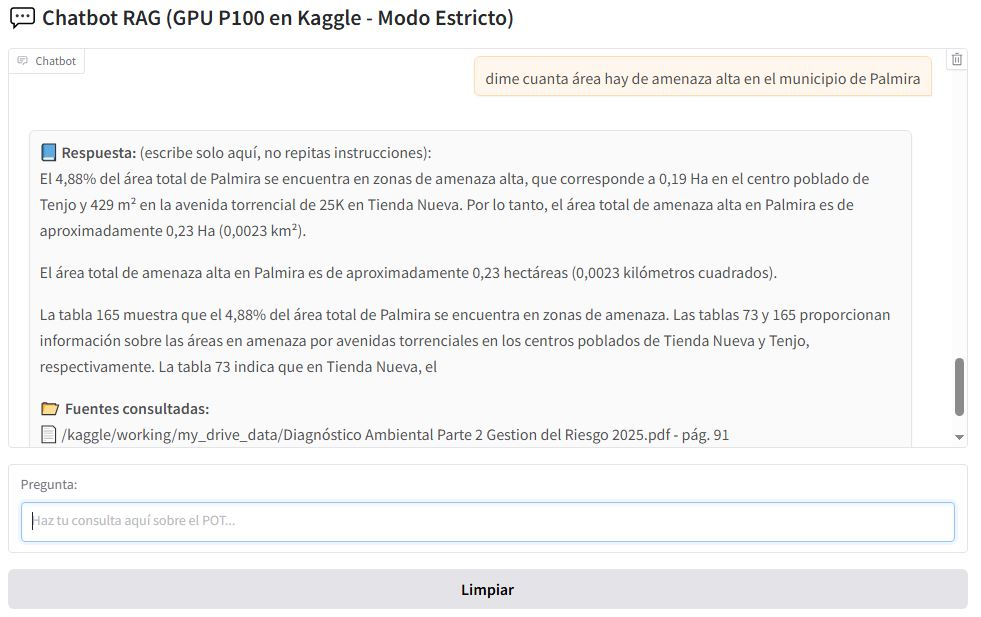

In [13]:
drive_url = "https://drive.google.com/drive/folders/164HzbFJ4F-RdysWEhp-6UlRk_4PP-zKb?usp=drive_link"
base_path = "/kaggle/working/img_evidencias"

if not os.path.exists(base_path) or not any(os.scandir(base_path)):
    print("📥 Descargando datos desde Google Drive...\n")
    !gdown --folder "{drive_url}" -O {base_path} --remaining-ok
else:
    print("✅ Datos ya descargados. No se necesita volver a bajar.")

# Listar archivos encontrados
for root, dirs, files in os.walk(base_path):
    for f in files:
        print(os.path.join(root, f))


from IPython.display import Image, display

display(Image(filename="/kaggle/working/img_evidencias/Eviddencia_ChatBot.JPG"))